In [1]:
import os
os.chdir('/home/rlange/modularity-io/')

In [2]:
import torch
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from analysis import load_data_as_table, generate_model_specs
from modularity import sort_by_cluster, girvan_newman
import itertools
from util import merge_dicts
from models import LitWrapper
from pprint import pprint
from pathlib import Path
from colorsys import hsv_to_rgb

%matplotlib inline

# Basic metrics

In [3]:
# # These are the regularization values we used; in all cases, L2 was set to a minimum value of 1e-5
# regularization = {
#     'l2': np.logspace(-5,-1,9),
#     'l1': np.logspace(-5,-1,9),
#     'drop': np.linspace(0.05, 0.7, 14)
# }

# These are the regularization values we want to analyze
regularization = {
    'l2': np.logspace(-5,-1,9),
    'l1': np.logspace(-5,-2,7),
    'drop': np.linspace(0.05, 0.7, 14)
}

In [4]:
metrics = ['train_loss', 'val_loss', 'test_loss', 'train_acc', 'val_acc', 'test_acc', 'l1_norm', 'l2_norm', 'sparsity', 'nuc_norm']
test_acc_cutoff = 0.8

basic_df_l2 = load_data_as_table(
    generate_model_specs({'dataset': 'mnist', 'task': 'sup', 'l1': 0.0, 'drop': 0.0,
                          'l2': regularization['l2'], 'run': range(9)}),
    metrics,
    log_dir=Path('logs-sup-l2'))

basic_df_l1 = load_data_as_table(
    generate_model_specs({'dataset': 'mnist', 'task': 'sup', 'l2': 1e-5, 'drop': 0.0,
                          'l1': regularization['l1'], 'run': range(9)}),
    metrics,
    log_dir=Path('logs-sup-l1'))

basic_df_drop = load_data_as_table(
    generate_model_specs({'dataset': 'mnist', 'task': 'sup', 'l2': 1e-5, 'drop': regularization['drop'],
                          'l1': 0., 'run': range(9)}),
    metrics,
    log_dir=Path('logs-sup-drop'))

basic_df_null = load_data_as_table(
    generate_model_specs({'dataset': 'mnist', 'task': 'sup', 'l2': 0., 'drop': 0., 'l1': 0.,
                          'run': range(1000,1500), 'checkpoint': 'dummy.ckpt'}),
    metrics,
    log_dir=Path('logs-dummy'))

basic_df_all = pd.concat([basic_df_l2, basic_df_l1, basic_df_drop])

In [5]:
def df_slice(df:pd.DataFrame, condition:dict):
    for key, val in condition.items():
        if val is None or (isinstance(val, float) and np.isnan(val)):
            df = df[np.isnan(df[key])]
        else:
            df = df[df[key] == val]
    return df


def plot_vs_hyper_by_run(df, x, y, ax=None, line_args={}, errbar_args={}, df_null=None):
    ax = ax or plt.gca()
    
    if df_null is not None:
        y_null = df_null[y]
        null_mean = y_null.mean()
        null_std = y_null.std()
        xlims = [df[x].min(), df[x].max()]
        for sigma in [1,2,3]:
            ax.fill_between(xlims, null_mean-sigma*null_std, null_mean+sigma*null_std,
                            color=(0.,0.,0.,0.1), edgecolor='none')
        ax.plot(xlims, [null_mean, null_mean], color=(.5,.5,.5))
    
    rgroups = df.groupby('run')
    for idx, grp in rgroups:
        grp.plot(x, y, ax=ax, **line_args)
    
    mu = df.groupby(x).mean()
    sem = df.groupby(x).agg(lambda x: x.std() / np.sqrt(x.count()))
    mu.plot(y=y, yerr=sem[y], ax=ax, ylabel=y, xlabel=x, **errbar_args)
    
    if errbar_args.get('legend', False):
        legend_handles = []
        legend_labels = []
        for splt in errbar_splits:
            if splt == 'assoc':
                items = ['forward', 'backward', 'cov/hess', 'jacobian', 'raw', 'norm']
            else:
                items = df[splt].unique()
            for v in items:
                legend_handles.append(Line2D([0], [0], **plot_format({splt: v})))
                legend_labels.append(str(v))
        plt.legend(legend_handles, legend_labels)

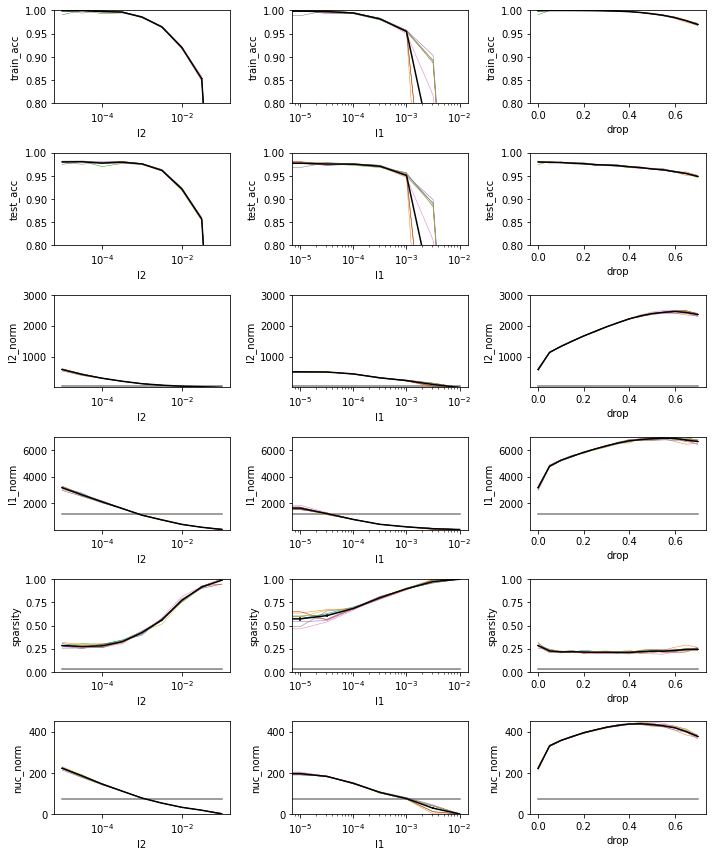

In [6]:
fig, ax = plt.subplots(6,3,figsize=(10, 12))

## TRAIN ACC ##
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l1':0.,'drop':0.}),
                     x='l2', y='train_acc', ax=ax[0,0],
                     line_args={'linewidth': 0.5, 'logx': True, 'legend':False, 'ylim': [test_acc_cutoff, 1.]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l2':1e-5,'drop':0.}),
                     x='l1', y='train_acc', ax=ax[0,1],
                     line_args={'linewidth': 0.5, 'logx': True, 'legend':False, 'ylim': [test_acc_cutoff, 1.]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l1':0.,'l2':1e-5}),
                     x='drop', y='train_acc', ax=ax[0,2],
                     line_args={'linewidth': 0.5, 'logx': False, 'legend':False, 'ylim': [test_acc_cutoff, 1.]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)

## TEST ACC ##
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l1':0.,'drop':0.}),
                     x='l2', y='test_acc', ax=ax[1,0],
                     line_args={'linewidth': 0.5, 'logx': True, 'legend':False, 'ylim': [test_acc_cutoff, 1.]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l2':1e-5,'drop':0.}),
                     x='l1', y='test_acc', ax=ax[1,1],
                     line_args={'linewidth': 0.5, 'logx': True, 'legend':False, 'ylim': [test_acc_cutoff, 1.]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l1':0.,'l2':1e-5}),
                     x='drop', y='test_acc', ax=ax[1,2],
                     line_args={'linewidth': 0.5, 'logx': False, 'legend':False, 'ylim': [test_acc_cutoff, 1.]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)

## L2 WEIGHT NORM ##
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l1':0.,'drop':0.}),
                     x='l2', y='l2_norm', ax=ax[2,0],
                     line_args={'linewidth': 0.5, 'logx': True, 'legend':False, 'ylim': [1, 3000]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l2':1e-5,'drop':0.}),
                     x='l1', y='l2_norm', ax=ax[2,1],
                     line_args={'linewidth': 0.5, 'logx': True, 'legend':False, 'ylim': [1, 3000]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l1':0.,'l2':1e-5}),
                     x='drop', y='l2_norm', ax=ax[2,2],
                     line_args={'linewidth': 0.5, 'logx': False, 'legend':False, 'ylim': [1, 3000]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)

## L1 WEIGHT NORM ##
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l1':0.,'drop':0.}),
                     x='l2', y='l1_norm', ax=ax[3,0],
                     line_args={'linewidth': 0.5, 'logx': True, 'legend':False, 'ylim': [1, 7000]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l2':1e-5,'drop':0.}),
                     x='l1', y='l1_norm', ax=ax[3,1],
                     line_args={'linewidth': 0.5, 'logx': True, 'legend':False, 'ylim': [1, 7000]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l1':0.,'l2':1e-5}),
                     x='drop', y='l1_norm', ax=ax[3,2],
                     line_args={'linewidth': 0.5, 'logx': False, 'legend':False, 'ylim': [1, 7000]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)

## SPARSITY ##
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l1':0.,'drop':0.}),
                     x='l2', y='sparsity', ax=ax[4,0],
                     line_args={'linewidth': 0.5, 'logx': True, 'legend':False, 'ylim': [0, 1]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l2':1e-5,'drop':0.}),
                     x='l1', y='sparsity', ax=ax[4,1],
                     line_args={'linewidth': 0.5, 'logx': True, 'legend':False, 'ylim': [0, 1]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l1':0.,'l2':1e-5}),
                     x='drop', y='sparsity', ax=ax[4,2],
                     line_args={'linewidth': 0.5, 'logx': False, 'legend':False, 'ylim': [0, 1]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)

## NUCLEAR NORM ##
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l1':0.,'drop':0.}),
                     x='l2', y='nuc_norm', ax=ax[5,0],
                     line_args={'linewidth': 0.5, 'logx': True, 'legend':False, 'ylim': [0, 450]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l2':1e-5,'drop':0.}),
                     x='l1', y='nuc_norm', ax=ax[5,1],
                     line_args={'linewidth': 0.5, 'logx': True, 'legend':False, 'ylim': [0, 450]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)
plot_vs_hyper_by_run(df_slice(basic_df_all, {'l1':0.,'l2':1e-5}),
                     x='drop', y='nuc_norm', ax=ax[5,2],
                     line_args={'linewidth': 0.5, 'logx': False, 'legend':False, 'ylim': [0, 450]},
                     errbar_args={'fmt': '-k', 'linewidth': 1.5, 'legend': False},
                     df_null=basic_df_null)
fig.tight_layout()
fig.savefig('figures/performance_and_norms.svg')
plt.show()

# Load and plot some association matrices

In [91]:
model_spec = {'dataset': 'mnist', 'task': 'sup', 'l2': 1e-5, 'l1':0.0, 'drop': 0.3, 'run': 6, 'layer': 0}
demo_ckpt = f'logs-sup-drop/{LitWrapper(**model_spec).get_uid()}/weights/last.ckpt'

info = torch.load(demo_ckpt)
mods = info["modules"]

def plot_assoc(A, ax=None, lines_at=None, line_args={}, colorbar=False, vmin=0., vmax=None):
    ax = ax or plt.gca()
    mat = ax.matshow(A, vmin=vmin, vmax=vmax)
    if colorbar:
        plt.colorbar(mat, ax=ax)
    if lines_at is not None:
        sz = len(A)
        line_args = merge_dicts({'color': 'r', 'linewidth':0.5}, line_args)
        for x in np.cumsum(lines_at)-0.5:
            ax.plot([-.5, sz-.5], [x, x], **line_args)
            ax.plot([x, x], [-.5, sz-.5], **line_args)
    ax.set_xticks([])
    ax.set_yticks([])

In [8]:
assoc_to_plot = ['forward_jac', 'backward_jac']


relabel = {
    'backward_hess': 'output hessian',
    'backward_hess_norm': 'output hessian (norm)',
    'backward_jac': 'output gradient',
    'backward_jac_norm': 'output gradient (norm)',
    'forward_cov': 'input covariance',
    'forward_cov_norm': 'input covariance (norm)',
    'forward_jac': 'input gradient',
    'forward_jac_norm': 'input gradient (norm)',
    'l2': '$L_2$',
    'l1': '$L_1$',
    'drop': 'drop',
}

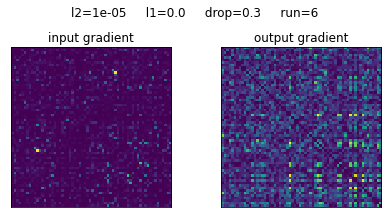

In [9]:
fig, ax = plt.subplots(1, len(assoc_to_plot), figsize=(3*len(assoc_to_plot), 3))
for i, a in enumerate(assoc_to_plot):
    adj, clust = mods[a][model_spec['layer']]['adj'].numpy(), mods[a][model_spec['layer']]['clusters'].numpy()
    adj = adj / adj.sum()
    plot_assoc(adj, ax[i])
    ax[i].set_title(relabel[a])
plt.suptitle("     ".join(f"{k}={model_spec[k]}" for k in ['l2', 'l1', 'drop', 'run']))
fig.tight_layout()
plt.show()

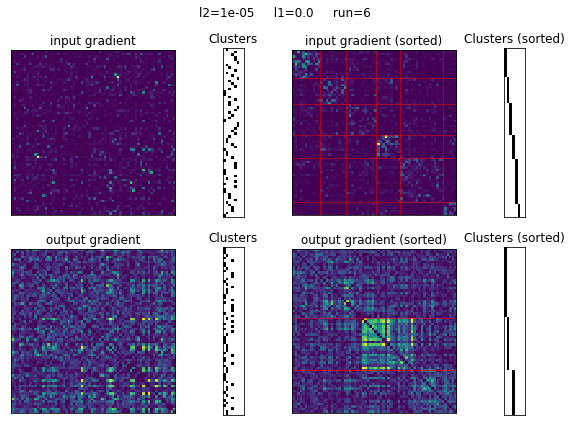

In [10]:
fig = plt.figure(figsize=(8, 3*len(assoc_to_plot)))
grid = GridSpec(len(assoc_to_plot), 16)

for i, a in enumerate(assoc_to_plot):
    # Plot assoc and clusters (unsorted)
    assoc_ax, clust_ax = fig.add_subplot(grid[i, 0:5]), fig.add_subplot(grid[i, 5:8])
    adj, clust = mods[a][model_spec['layer']]['adj'].numpy(), mods[a][model_spec['layer']]['clusters'].numpy()

    plot_assoc(adj, ax=assoc_ax)
    assoc_ax.set_title(relabel[a])
    
    clust_ax.matshow(1-clust[:, :8], cmap='gray')
    clust_ax.set_xticks([]); clust_ax.set_yticks([])
    clust_ax.set_title('Clusters')
    
    # Plot assoc and clusters (sorted)
    isrt = sort_by_cluster(clust)
    assoc_ax, clust_ax = fig.add_subplot(grid[i, 8:13]), fig.add_subplot(grid[i, 13:16])
    isrt = sort_by_cluster(clust, remove_dead=True)

    plot_assoc(adj[isrt,:][:,isrt], ax=assoc_ax, lines_at=clust.sum(0))
    assoc_ax.set_title(relabel[a]+" (sorted)")
    
    clust_ax.matshow(1-clust[isrt, :8], cmap='gray')
    clust_ax.set_xticks([]); clust_ax.set_yticks([])
    clust_ax.set_title('Clusters (sorted)')
plt.suptitle("     ".join(f"{k}={model_spec[k]}" for k in ['l2', 'l1', 'run']))
fig.tight_layout()
plt.show()

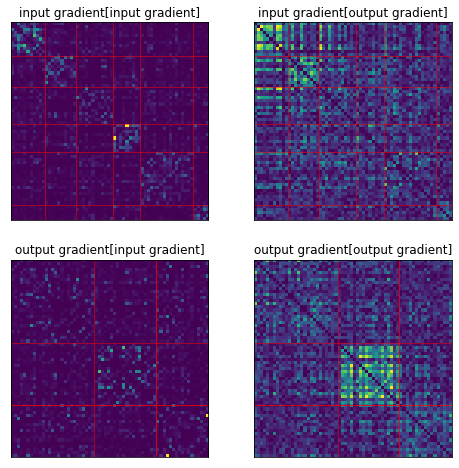

In [11]:
fig, ax = plt.subplots(len(assoc_to_plot), len(assoc_to_plot), figsize=(4*len(assoc_to_plot), 4*len(assoc_to_plot)))
for i, ai in enumerate(assoc_to_plot):
    adj_i, clust_i = mods[ai][model_spec['layer']]['adj'].numpy(), mods[ai][model_spec['layer']]['clusters'].numpy()
    adj_i = adj_i / adj_i.sum()
    sizes_i = clust_i.sum(axis=0)
    sort_i = np.argsort(np.argmax(clust_i, axis=1))
    # remove dead units from sorting indices
    sort_i = np.array([idx for idx in sort_i if not clust_i[idx,:].sum()==0.])

    for j, aj in enumerate(assoc_to_plot):
        adj_j = mods[aj][model_spec['layer']]['adj'].numpy()
        adj_j = adj_j / adj_j.sum()
        plot_assoc(adj_j[sort_i,:][:,sort_i], lines_at=sizes_i, ax=ax[i,j])
        ax[i,j].set_title(relabel[ai]+"["+relabel[aj]+"]")
plt.show()

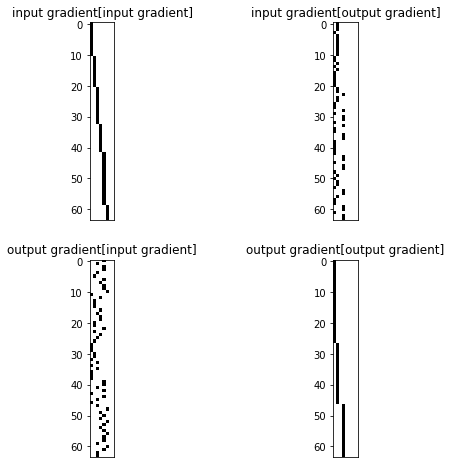

In [12]:
fig, ax = plt.subplots(len(assoc_to_plot), len(assoc_to_plot), figsize=(4*len(assoc_to_plot), 4*len(assoc_to_plot)))
for i, ai in enumerate(assoc_to_plot):
    clust_i = mods[ai][model_spec['layer']]['clusters'].numpy()
    sort_i = sort_by_cluster(clust_i, remove_dead=True)

    for j, aj in enumerate(assoc_to_plot):
        clust_j = mods[aj][model_spec['layer']]['clusters'].numpy()
        ax[i,j].matshow(1-clust_j[sort_i, :8], cmap='gray')
        ax[i,j].set_xticks([]); clust_ax.set_yticks([])
        ax[i,j].set_title(relabel[ai]+"["+relabel[aj]+"]")
plt.show()

# Modularity series plotting helpers

In [13]:
def _isinput(assoc:str):
    return ('forward' in assoc) or ('input' in assoc)

def _isgrad(assoc:str):
    return ('jac' in assoc) or ('grad' in assoc)

def _isnorm(assoc:str):
    return '_norm' in assoc


def regularization_amount(hyp:str, val):
    if hyp == 'l2':
        return (np.log(val) - np.log(min(regularization['l2']))) / (np.log(max(regularization['l2'])) - np.log(min(regularization['l2'])))
    elif hyp == 'l1':
        return (np.log(val) - np.log(min(regularization['l1']))) / (np.log(max(regularization['l1'])) - np.log(min(regularization['l1'])))
    elif hyp == 'drop':
        return val


def p_string(pvalue, n_comparisons=1):
    if pvalue < 0.001/n_comparisons:
        return '***'
    elif pvalue < 0.01/n_comparisons:
        return '**'
    elif pvalue < 0.05/n_comparisons:
        return '*'
    else:
        return ''


def plot_format(group_identifier: dict, seed_hue=1/6):
    h, s, v, marker = seed_hue, 0.9, 0.5, '.'
    for k, v in group_identifier.items():
        if k == 'assoc':
            h = seed_hue if _isinput(v) else seed_hue-1/4
            h += (+1/4 if _isinput(v) else -1/4) * _isgrad(v)
            v = 0.5 if _isnorm(v) else 0.9
        elif k == 'layer':
            marker = 'o^'[v]
    return {'marker': marker, 'color': hsv_to_rgb(h%1.0,s,v)}


def plot_vs_hyper_splits(df, x, y, std_hyper=False, ax=None, errbar_splits=['assoc'], errbar_args={}, df_null=None, null_color=(0.,0.,0.)):
    ax = ax or plt.gca()
    
    if std_hyper:
        df[x] = regularization_amount(x, df[x])
        x_name = 'reg. amt'
    else:
        x_name = x
        
    if df_null is not None:
        y_null = df_null[y]
        null_mean = y_null.mean()
        null_std = y_null.std()
        xlims = [df[x].min(), df[x].max()]
        for sigma in [1,2,3]:
            ax.fill_between(xlims, null_mean-sigma*null_std, null_mean+sigma*null_std,
                            color=null_color+(0.1,), edgecolor='none')
        ax.plot(xlims, [null_mean, null_mean], color=null_color)
    
    for idx, grp in df.groupby(errbar_splits):
        args = {'xlabel': x_name, 'ylabel': y, 'label': str(idx)}
        args.update(errbar_args)
        t_idx = (idx,) if not isinstance(idx, tuple) else idx
        mu = grp.groupby(x).mean()
        sem = grp.groupby(x).agg(lambda x: x.std() / np.sqrt(x.count()))
        mu.plot(y=y, yerr=sem[y], ax=ax, **merge_dicts(plot_format(dict(zip(errbar_splits, t_idx))), args))

Make a cube legend showing 2x2x2 splits between association methods

# Modularity metrics vs hyperparameters

In [59]:
assoc = ["forward_cov", "backward_hess", "forward_jac", "backward_jac"]
norms = ["", "_norm"]
all_assoc = [f"{io+nm}" for (io,nm) in itertools.product(assoc,norms)]
fields = ("score", "num_clusters", "adj")
layers = [0,1]
mod_metrics = [f"modules.{a}.{lay}.{field}" for (a, lay, field) in itertools.product(all_assoc, layers, fields)]
mod_metrics.append("test_acc")

mod_df_l2 = load_data_as_table(
    generate_model_specs({'dataset': 'mnist', 'task': 'sup', 'l1': 0.0, 'drop': 0.0,
                          'l2': regularization['l2'], 'run': range(9)}),
    mod_metrics,
    log_dir=Path('logs-sup-l2'))

mod_df_l1 = load_data_as_table(
    generate_model_specs({'dataset': 'mnist', 'task': 'sup', 'l2': 1e-5, 'drop': 0.0,
                          'l1': regularization['l1'], 'run': range(9)}),
    mod_metrics,
    log_dir=Path('logs-sup-l1'))

mod_df_drop = load_data_as_table(
    generate_model_specs({'dataset': 'mnist', 'task': 'sup', 'l2': 1e-5, 'drop': regularization['drop'],
                          'l1': 0.0, 'run': range(9)}),
    mod_metrics,
    log_dir=Path('logs-sup-drop'))

mod_df_null = load_data_as_table(
    generate_model_specs({'dataset': 'mnist', 'task': 'sup', 'l2': 0.0, 'drop': 0.0, 'l1': 0.0, 'run': range(1000, 1500), 'checkpoint': 'dummy.ckpt'}),
    mod_metrics,
    log_dir=Path('logs-dummy'))

mod_df_all = pd.concat([mod_df_l2, mod_df_l1, mod_df_drop])

# Drop modularity metrics wherever test_acc < test_acc_cutoff
mod_df_l2.loc[mod_df_l2["test_acc"] < test_acc_cutoff, fields] = float('nan')
mod_df_l1.loc[mod_df_l1["test_acc"] < test_acc_cutoff, fields] = float('nan')
mod_df_drop.loc[mod_df_drop["test_acc"] < test_acc_cutoff, fields] = float('nan')
mod_df_all.loc[mod_df_all["test_acc"] < test_acc_cutoff, fields] = float('nan')

Brief aside to inspect histogram of raw association scores ($\mathbf{A}$ in the paper)

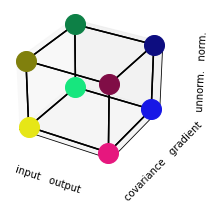

forward_cov #E5E516
forward_cov_norm #7F7F0C
backward_hess #E5167E
backward_hess_norm #7F0C46
forward_jac #16E57E
forward_jac_norm #0C7F46
backward_jac #1616E5
backward_jac_norm #0C0C7F


In [15]:
msize = 20
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1,projection='3d')
xyz = list(itertools.product((0,1),(0,1),(0,1)))
for (x1,y1,z1),(x2,y2,z2) in itertools.product(xyz,xyz):
    if abs(x2-x1)+abs(y2-y1)+abs(z2-z1)==1:
        plt.plot((x1,x2),(y1,y2),(z1,z2),'-k')
ax.plot(0,0,0,**merge_dicts(plot_format({'assoc':'forward_cov'}), {'marker':'o','markersize':msize}))
ax.plot(1,0,0,**merge_dicts(plot_format({'assoc':'backward_hess'}), {'marker':'o','markersize':msize}))
ax.plot(0,1,0,**merge_dicts(plot_format({'assoc':'forward_jac'}), {'marker':'o','markersize':msize}))
ax.plot(1,1,0,**merge_dicts(plot_format({'assoc':'backward_jac'}), {'marker':'o','markersize':msize}))
ax.plot(0,0,1,**merge_dicts(plot_format({'assoc':'forward_cov_norm'}), {'marker':'o','markersize':msize}))
ax.plot(1,0,1,**merge_dicts(plot_format({'assoc':'backward_hess_norm'}), {'marker':'o','markersize':msize}))
ax.plot(0,1,1,**merge_dicts(plot_format({'assoc':'forward_jac_norm'}), {'marker':'o','markersize':msize}))
ax.plot(1,1,1,**merge_dicts(plot_format({'assoc':'backward_jac_norm'}), {'marker':'o','markersize':msize}))
ax.set_xticks([]); ax.set_xlabel('input   output')
ax.set_yticks([]); ax.set_ylabel('covariance   gradient')
ax.set_zticks([]); ax.set_zlabel('unnorm.   norm.')
plt.show()

for a in all_assoc:
    print(a, "#"+"".join(["%02X"%int(255.*val) for val in plot_format({'assoc':a})['color']]))

### Inspect modularity metrics' distribution in untrained models

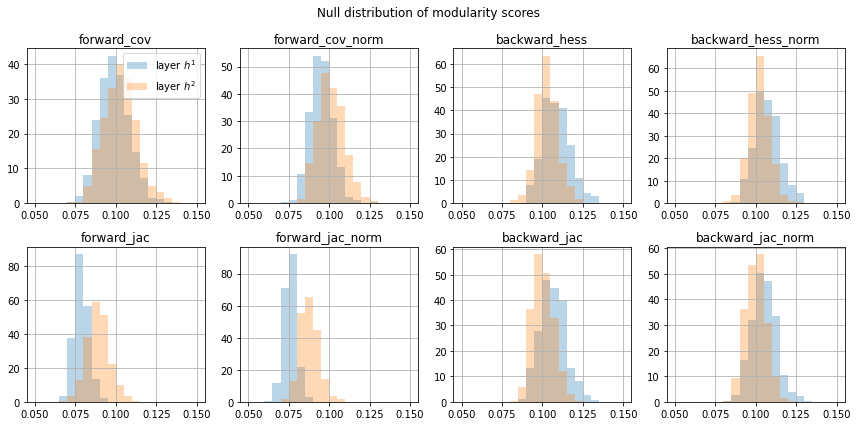

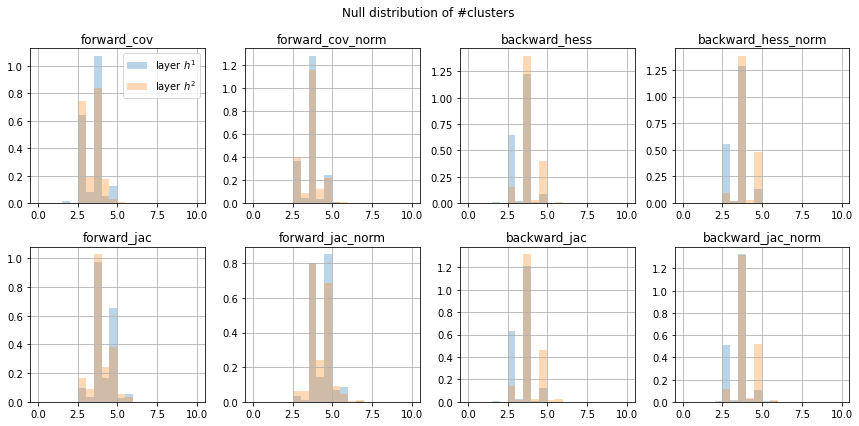

In [16]:
fig,ax = plt.subplots(2,4,figsize=(12,6))
for i, a in enumerate(all_assoc):
    df_slice(mod_df_null, {'assoc':a}).groupby('layer')\
        .hist(column='score', ax=ax[i//4,i%4], alpha=0.3, bins=np.linspace(.05,.15,21), density=True)
    ax[i//4,i%4].set_title(a)
ax[0,0].legend(['layer $h^1$', 'layer $h^2$'])
fig.suptitle('Null distribution of modularity scores')
fig.tight_layout()
plt.show()

fig,ax = plt.subplots(2,4,figsize=(12,6))
for i, a in enumerate(all_assoc):
    df_slice(mod_df_null, {'assoc':a}).groupby('layer')\
        .hist(column='num_clusters', ax=ax[i//4,i%4], alpha=0.3, bins=np.linspace(0.,10.,21), density=True)
    ax[i//4,i%4].set_title(a)
ax[0,0].legend(['layer $h^1$', 'layer $h^2$'])
fig.suptitle('Null distribution of #clusters')
fig.tight_layout()
plt.show()

### NMC plot 1a: Q score vs hyper, separate panel per assoc method

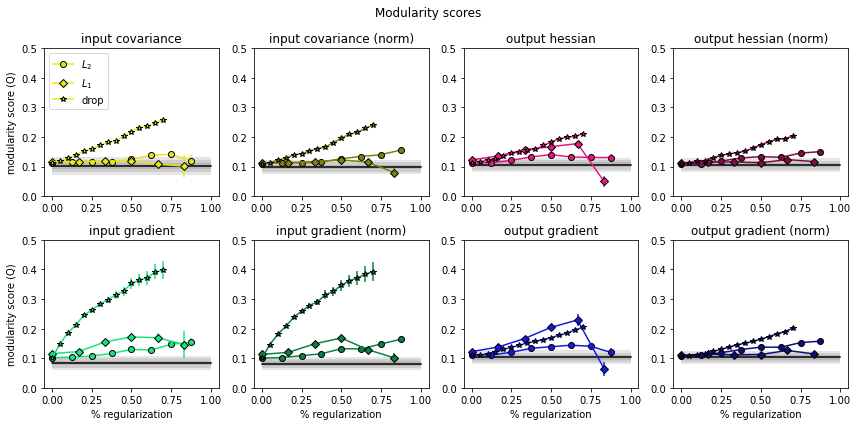

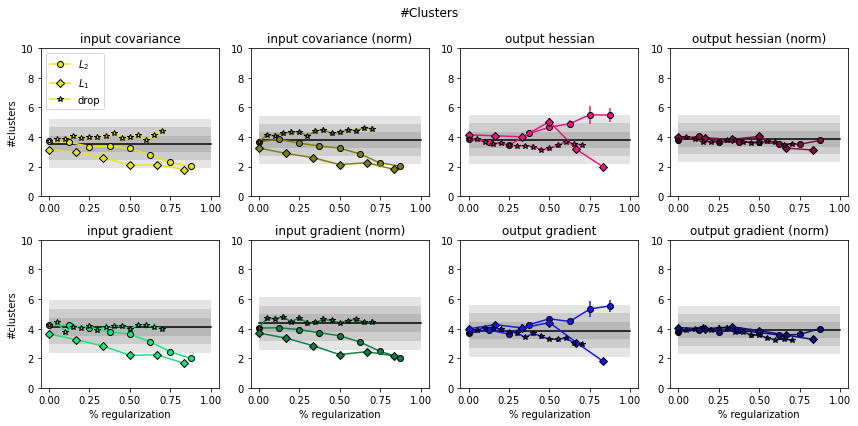

In [17]:
%%capture --no-display
color0 = plot_format({'assoc': all_assoc[0]})['color']
fig, ax = plt.subplots(2, 4, figsize=(12,6))

for i, a in enumerate(all_assoc):
    r, c = i//4, i%4
    plot_vs_hyper_splits(df=df_slice(mod_df_all, {'l1':0.,'drop':0.,'assoc':a}),
                         x='l2', y='score', ax=ax[r,c], std_hyper=True,
                         errbar_args={'marker':'o', 'markeredgecolor':'k', 'ylim': [0.0, 0.5], 'legend': False, 'ylabel': None, 'xlabel': None},
                         df_null=df_slice(mod_df_null, {'assoc':a}))
    plot_vs_hyper_splits(df=df_slice(mod_df_all, {'l2':1e-5,'drop':0.,'assoc':a}),
                         x='l1', y='score', ax=ax[r,c], std_hyper=True,
                         errbar_args={'marker':'D', 'markeredgecolor':'k', 'ylim': [0.0, 0.5], 'legend': False, 'ylabel': None, 'xlabel': None})
    plot_vs_hyper_splits(df=df_slice(mod_df_all, {'l2':1e-5,'l1':0.,'assoc':a}),
                         x='drop', y='score', ax=ax[r,c], std_hyper=True,
                         errbar_args={'marker':'*', 'markeredgecolor':'k', 'ylim': [0.0, 0.5], 'legend': False, 'ylabel': None, 'xlabel': None})
    ax[r,c].set_title(relabel[a])
    ax[r,c].set_ylabel('modularity score (Q)' if c==0 else None)
    ax[r,c].set_xlabel('% regularization' if r==1 else None)

ax[0,0].legend(loc='upper left', handles=[Line2D([0],[0], color=color0, markeredgecolor='k', marker='o', label='$L_2$'),
                                          Line2D([0],[0], color=color0, markeredgecolor='k', marker='D', label='$L_1$'),
                                          Line2D([0],[0], color=color0, markeredgecolor='k', marker='*', label='drop')])

fig.suptitle('Modularity scores')

fig.tight_layout()
fig.savefig('figures/q_vs_reg.svg')
plt.show()

# Do it again but for #clusters
fig, ax = plt.subplots(2, 4, figsize=(12,6))

for i, a in enumerate(all_assoc):
    r, c = i//4, i%4
    plot_vs_hyper_splits(df=df_slice(mod_df_all, {'l1':0.,'drop':0.,'assoc':a}),
                         x='l2', y='num_clusters', ax=ax[r,c], std_hyper=True,
                         errbar_args={'marker':'o', 'markeredgecolor':'k', 'ylim': [0, 10], 'legend': False, 'ylabel': None, 'xlabel': None},
                         df_null=df_slice(mod_df_null, {'assoc':a}))
    plot_vs_hyper_splits(df=df_slice(mod_df_all, {'l2':1e-5,'drop':0.,'assoc':a}),
                         x='l1', y='num_clusters', ax=ax[r,c], std_hyper=True,
                         errbar_args={'marker':'D', 'markeredgecolor':'k', 'ylim': [0, 10], 'legend': False, 'ylabel': None, 'xlabel': None})
    plot_vs_hyper_splits(df=df_slice(mod_df_all, {'l2':1e-5,'l1':0.,'assoc':a}),
                         x='drop', y='num_clusters', ax=ax[r,c], std_hyper=True,
                         errbar_args={'marker':'*', 'markeredgecolor':'k', 'ylim': [0, 10], 'legend': False, 'ylabel': None, 'xlabel': None})
    ax[r,c].set_title(relabel[a])
    ax[r,c].set_ylabel('#clusters' if c==0 else None)
    ax[r,c].set_xlabel('% regularization' if r==1 else None)

ax[0,0].legend(loc='upper left', handles=[Line2D([0],[0], color=color0, markeredgecolor='k', marker='o', label='$L_2$'),
                                          Line2D([0],[0], color=color0, markeredgecolor='k', marker='D', label='$L_1$'),
                                          Line2D([0],[0], color=color0, markeredgecolor='k', marker='*', label='drop')])

fig.suptitle('#Clusters')
fig.tight_layout()
fig.savefig('figures/numc_vs_reg.svg')
plt.show()

### Repeat the above, now additionally splitting by layer

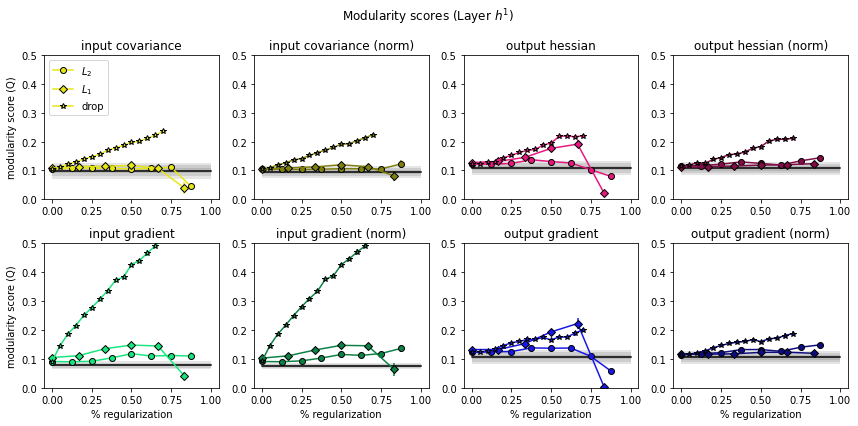

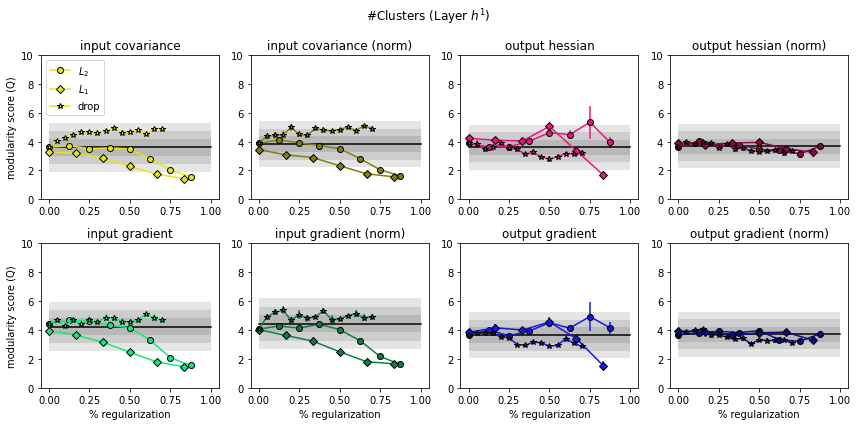

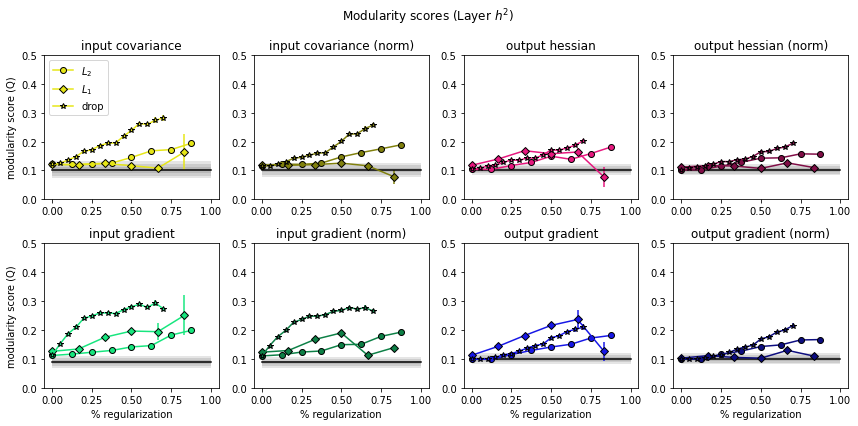

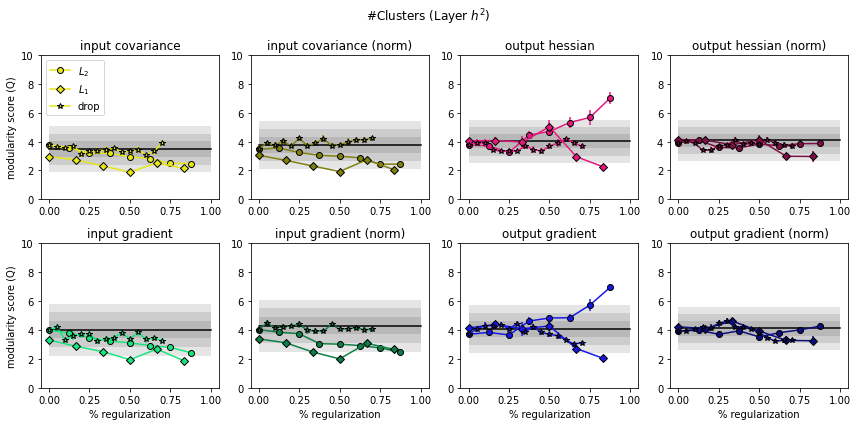

In [18]:
%%capture --no-display
color0 = plot_format({'assoc': all_assoc[0]})['color']

for l in layers:
    fig, ax = plt.subplots(2, 4, figsize=(12,6))
    for i, a in enumerate(all_assoc):
        r, c = i//4, i%4
        plot_vs_hyper_splits(df=df_slice(mod_df_all, {'l1':0.,'drop':0.,'assoc':a,'layer':l}),
                             x='l2', y='score', ax=ax[r,c], std_hyper=True,
                             errbar_args={'marker':'o', 'markeredgecolor':'k', 'ylim': [0.0, 0.5], 'legend': False, 'ylabel': None, 'xlabel': None},
                             df_null=df_slice(mod_df_null, {'assoc':a,'layer':l}))
        plot_vs_hyper_splits(df=df_slice(mod_df_all, {'l2':1e-5,'drop':0.,'assoc':a,'layer':l}),
                             x='l1', y='score', ax=ax[r,c], std_hyper=True,
                             errbar_args={'marker':'D', 'markeredgecolor':'k', 'ylim': [0.0, 0.5], 'legend': False, 'ylabel': None, 'xlabel': None})
        plot_vs_hyper_splits(df=df_slice(mod_df_all, {'l2':1e-5,'l1':0.,'assoc':a,'layer':l}),
                             x='drop', y='score', ax=ax[r,c], std_hyper=True,
                             errbar_args={'marker':'*', 'markeredgecolor':'k', 'ylim': [0.0, 0.5], 'legend': False, 'ylabel': None, 'xlabel': None})
        ax[r,c].set_title(relabel[a])
        ax[r,c].set_ylabel('modularity score (Q)' if c==0 else None)
        ax[r,c].set_xlabel('% regularization' if r==1 else None)

    ax[0,0].legend(loc='upper left', handles=[Line2D([0],[0], color=color0, markeredgecolor='k', marker='o', label='$L_2$'),
                                              Line2D([0],[0], color=color0, markeredgecolor='k', marker='D', label='$L_1$'),
                                              Line2D([0],[0], color=color0, markeredgecolor='k', marker='*', label='drop')])
    
    fig.suptitle(f'Modularity scores (Layer $h^{l+1}$)')
    fig.tight_layout()
    fig.savefig(f'figures/q_vs_reg_h{l+1}.svg')
    plt.show()

    # Do it again but for #clusters
    fig, ax = plt.subplots(2, 4, figsize=(12,6))
    for i, a in enumerate(all_assoc):
        r, c = i//4, i%4
        plot_vs_hyper_splits(df=df_slice(mod_df_all, {'l1':0.,'drop':0.,'assoc':a,'layer':l}),
                             x='l2', y='num_clusters', ax=ax[r,c], std_hyper=True,
                             errbar_args={'marker':'o', 'markeredgecolor':'k', 'ylim': [0.0, 10], 'legend': False, 'ylabel': None, 'xlabel': None},
                             df_null=df_slice(mod_df_null, {'assoc':a,'layer':l}))
        plot_vs_hyper_splits(df=df_slice(mod_df_all, {'l2':1e-5,'drop':0.,'assoc':a,'layer':l}),
                             x='l1', y='num_clusters', ax=ax[r,c], std_hyper=True,
                             errbar_args={'marker':'D', 'markeredgecolor':'k', 'ylim': [0.0, 10], 'legend': False, 'ylabel': None, 'xlabel': None})
        plot_vs_hyper_splits(df=df_slice(mod_df_all, {'l2':1e-5,'l1':0.,'assoc':a,'layer':l}),
                             x='drop', y='num_clusters', ax=ax[r,c], std_hyper=True,
                             errbar_args={'marker':'*', 'markeredgecolor':'k', 'ylim': [0.0, 10], 'legend': False, 'ylabel': None, 'xlabel': None})
        ax[r,c].set_title(relabel[a])
        ax[r,c].set_ylabel('modularity score (Q)' if c==0 else None)
        ax[r,c].set_xlabel('% regularization' if r==1 else None)

    ax[0,0].legend(loc='upper left', handles=[Line2D([0],[0], color=color0, markeredgecolor='k', marker='o', label='$L_2$'),
                                              Line2D([0],[0], color=color0, markeredgecolor='k', marker='D', label='$L_1$'),
                                              Line2D([0],[0], color=color0, markeredgecolor='k', marker='*', label='drop')])
    
    fig.suptitle(f'#Clusters (Layer $h^{l+1}$)')
    fig.tight_layout()
    fig.savefig(f'figures/numc_vs_reg_h{l+1}.svg')
    plt.show()

### Pick some more assocation matrices to look at based on what we see here

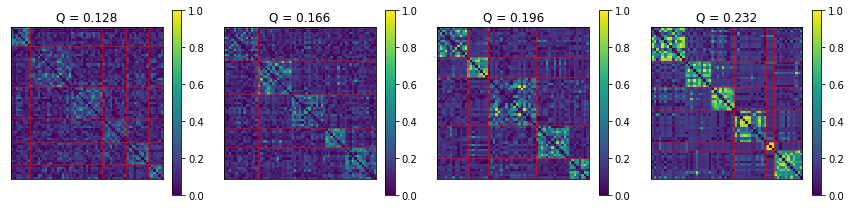

In [27]:
def load_and_plot_assoc(savedir, model_spec, layer, assoc, ax=None, title=None):
    ax=ax or plt.gca()
    demo_ckpt = Path(savedir) / LitWrapper(**model_spec).get_uid() / 'weights' / 'last.ckpt'
    info = torch.load(demo_ckpt, map_location='cpu')
    adj, clust = info["modules"][assoc][layer]['adj'], info["modules"][assoc][layer]['clusters']
    isrt = sort_by_cluster(clust, remove_dead=True)
    sizes = clust.sum(0)
    plot_assoc(adj[:,isrt][isrt,:], ax=ax, lines_at=sizes, colorbar=True)
    ttl = f"Q = {girvan_newman(adj,clust):.3f}"
    if title is not None:
        ttl += "\n" + title
    ax.set_title(ttl)


base_spec = {'dataset': 'mnist', 'task': 'sup', 'l2': 1e-5, 'l1':0.0, 'drop':0.0, 'run': 1}

fig, ax = plt.subplots(1,4,figsize=(12,3))
for i, d in enumerate([0.1, 0.3, 0.5, 0.7]):
    load_and_plot_assoc('logs-sup-drop', merge_dicts(base_spec, {'drop': d}), ax=ax[i], layer=0, assoc='forward_cov_norm')
fig.tight_layout()
fig.savefig('figures/example_assoc_vs_drop.svg')
plt.show()


# TODO: DO SINGULAR VALUES

# How well do methods agree?

## Idea 1: scatter scores

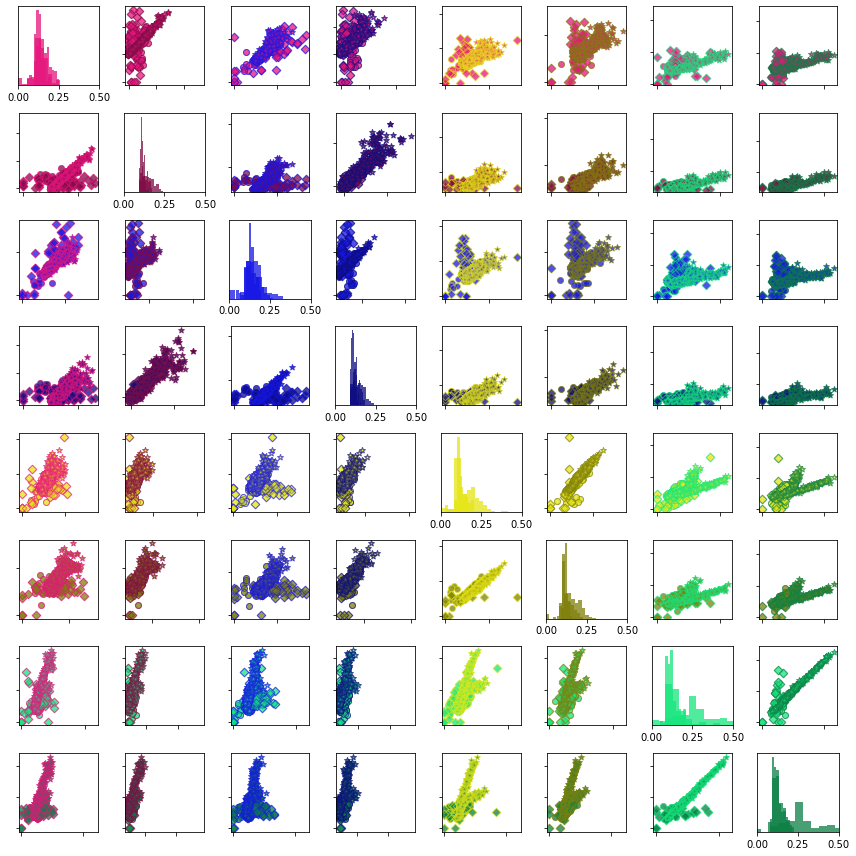

In [20]:
scatter_df = mod_df_all
fig, ax = plt.subplots(len(all_assoc), len(all_assoc), figsize=(1.5*len(all_assoc), 1.5*len(all_assoc)))
for marker, cond in zip('oD*', [{'l1':0.,'drop':0.},{'l2':1e-5,'drop':0.},{'l2':1e-5,'l1':0.}]):
    for i, assoc_i in enumerate(sorted(all_assoc)):
        for j, assoc_j in enumerate(sorted(all_assoc)):
            for l in layers:
                fmt_i, fmt_j = plot_format({'assoc': assoc_i}), plot_format({'assoc': assoc_j})
                df_slice_i = df_slice(scatter_df, merge_dicts(cond, {'assoc': assoc_i}))
                df_slice_j = df_slice(scatter_df, merge_dicts(cond, {'assoc': assoc_j}))
                if i == j:
                    ax[i,j].hist(df_slice_j['score'], histtype='stepfilled', color=fmt_i['color'], density=True, alpha=0.5)
                    ax[i,j].set_yticks([])
                    ax[i,j].set_xlim([0.,0.5])
                else:
                    ax[i,j].scatter(df_slice_j['score'], df_slice_i['score'], marker=marker,
                                    color=fmt_i['color'], edgecolor=fmt_j['color'], alpha=0.5)
                    ax[i,j].set_xlim([0.,0.5]); ax[i,j].set_ylim([0.,0.5])
                    ax[i,j].axis('square')
                    ax[i,j].set_xticklabels([]); ax[i,j].set_yticklabels([])
fig.tight_layout()
plt.show()

... same for #clusters?

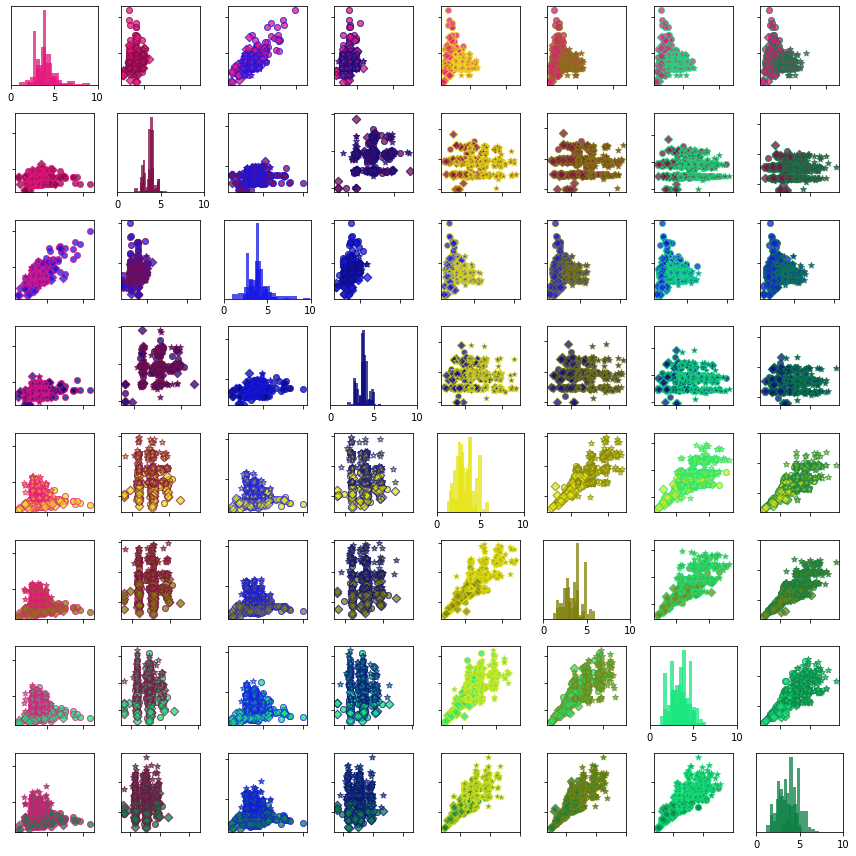

In [21]:
scatter_df = mod_df_all
fig, ax = plt.subplots(len(all_assoc), len(all_assoc), figsize=(1.5*len(all_assoc), 1.5*len(all_assoc)))
for marker, cond in zip('oD*', [{'l1':0.,'drop':0.},{'l2':1e-5,'drop':0.},{'l2':1e-5,'l1':0.}]):
    for i, assoc_i in enumerate(sorted(all_assoc)):
        for j, assoc_j in enumerate(sorted(all_assoc)):
            for l in layers:
                fmt_i, fmt_j = plot_format({'assoc': assoc_i}), plot_format({'assoc': assoc_j})
                df_slice_i = df_slice(scatter_df, merge_dicts(cond, {'assoc': assoc_i}))
                df_slice_j = df_slice(scatter_df, merge_dicts(cond, {'assoc': assoc_j}))
                if i == j:
                    ax[i,j].hist(df_slice_j['num_clusters'], histtype='stepfilled', color=fmt_i['color'], density=True, alpha=0.5)
                    ax[i,j].set_yticks([])
                    ax[i,j].set_xlim([0.,10])
                else:
                    ax[i,j].scatter(df_slice_j['num_clusters'], df_slice_i['num_clusters'], marker=marker,
                                    color=fmt_i['color'], edgecolor=fmt_j['color'], alpha=0.5)
                    ax[i,j].set_xlim([0.,10]); ax[i,j].set_ylim([0.,10])
                    ax[i,j].axis('square')
                    ax[i,j].set_xticklabels([]); ax[i,j].set_yticklabels([])
fig.tight_layout()
plt.show()

### Summarize all of these scatters with correlation matrices

Note: we will compute spearman correlation of each value, across hyper values and runs, separately per layer

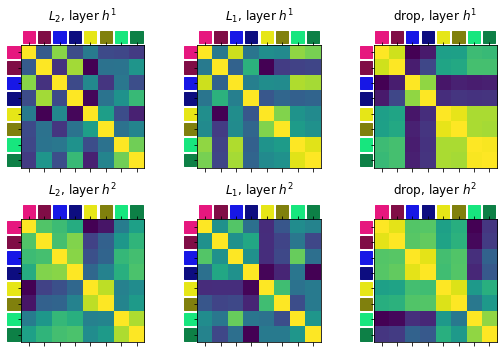

In [22]:
panelsize=2.5
textlabel=False
fig, ax = plt.subplots(len(layers), 3, figsize=(panelsize*3, panelsize*len(layers)))
for i, lay in enumerate(layers):
    for j, (hyp, cond) in enumerate(zip(['l2', 'l1', 'drop'], [{'l1':0.,'drop':0.},{'l2':1e-5,'drop':0.},{'l2':1e-5,'l1':0.}])):
        df = df_slice(mod_df_all, merge_dicts(cond, {'layer': lay}))
        pvt = df[df['layer']==lay].pivot(index=['l1', 'l2', 'drop', 'run'], columns=['assoc'], values=['score'])
        correlations = pvt.corr(method='spearman')
        labels = correlations['score'].columns
        ax[i,j].matshow(correlations)
        ax[i,j].set_xticks(range(len(labels)))
        ax[i,j].set_yticks(range(len(labels)))
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        barsize = 4.7 if textlabel else 0.8
        for k, a in enumerate(labels):
            ax[i,j].add_patch(Rectangle((k-.4,-barsize-.6),.8,barsize,fill=True,clip_on=False,color=plot_format({'assoc':a})['color']))
            ax[i,j].add_patch(Rectangle((-barsize-.6,k-.4),barsize,.8,fill=True,clip_on=False,color=plot_format({'assoc':a})['color']))
        if textlabel:
            ax[i,j].set_xticklabels([relabel[l] for l in labels], rotation=90, color='w')
            ax[i,j].set_yticklabels([relabel[l] for l in labels], color='w')
        ax[i,j].set_title(f'{relabel[hyp]}, layer $h^{lay+1}$\n')
fig.tight_layout()
plt.show()

# Module alignment

In [23]:
assoc = ["forward_cov", "backward_hess", "forward_jac", "backward_jac"]
norms = ["", "_norm"]
fields = ["score", "p", "version","rmi","vi","rmi_norm","vi_norm","element_sim","adj_spearman_r","adj_spearman_p"]
layers = [0,1]
sparsenesses = [""]#+[f".{f:.2f}" for f in [.05,.1,.2,.3,.4,.5]]

metrics = set()
for (io1, nm1, io2, nm2, sp, lay, field) in itertools.product(assoc, norms, assoc, norms, sparsenesses, layers, fields):
    assoc_a, assoc_b = min([io1+nm1, io2+nm2]), max([io1+nm1, io2+nm2])
    metrics.add(f"align.{assoc_a}:{assoc_b}{sp}.{lay}.{field}")
metrics.add("test_acc")

align_df_l2 = load_data_as_table(
    generate_model_specs({'dataset': 'mnist', 'task': 'sup', 'l1': 0.0, 'drop': 0.0,
                          'l2': np.logspace(-5,-1,9), 'run': range(9)}),
    metrics,
    log_dir=Path('logs-sup-l2'))

align_df_l1 = load_data_as_table(
    generate_model_specs({'dataset': 'mnist', 'task': 'sup', 'l2': 1e-5, 'drop': 0.0,
                          'l1': np.logspace(-5,-1,9), 'run': range(9)}),
    metrics,
    log_dir=Path('logs-sup-l1'))

align_df_drop = load_data_as_table(
    generate_model_specs({'dataset': 'mnist', 'task': 'sup', 'l2': 1e-5, 'l1': 0.0,
                          'drop': np.linspace(0.05, 0.7, 14), 'run': range(9)}),
    metrics,
    log_dir=Path('logs-sup-drop'))

align_df_null = load_data_as_table(
    generate_model_specs({'dataset': 'mnist', 'task': 'sup', 'l2': 0., 'drop': 0., 'l1': 0.,
                          'run': range(1000,1500), 'checkpoint': 'dummy.ckpt'}),
    metrics,
    log_dir=Path('logs-dummy'))

align_df_all = pd.concat([align_df_l2, align_df_l1, align_df_drop])

# Drop alignment metrics wherever test_acc < test_acc_cutoff
align_df_l2.loc[align_df_l2["test_acc"] < test_acc_cutoff, fields] = float('nan')
align_df_l1.loc[align_df_l1["test_acc"] < test_acc_cutoff, fields] = float('nan')
align_df_drop.loc[align_df_drop["test_acc"] < test_acc_cutoff, fields] = float('nan')
align_df_all.loc[align_df_all["test_acc"] < test_acc_cutoff, fields] = float('nan')


In [24]:
def alignment_stats(df, value='score'):
    pvt = df.pivot(index=('l1','l2','drop','run','layer'), columns=['assoc_a', 'assoc_b'], values=[value])
    average = pvt.mean()[value]
    
    assoc = df['assoc_a'].unique()
    assoc.sort()
    out = np.zeros((len(assoc), len(assoc)))
    for i, a in enumerate(assoc):
        for j, b in enumerate(assoc):
            out[i,j] = average.loc[(min(a,b),max(a,b))]
    return out, assoc

rg = LinearSegmentedColormap('redgreen',
                             {'red': [(0.,1.,1.),(.5,0.,0.),(1.,0.,0.)],
                              'green': [(0.,0.,0.),(.5,0.,0.),(1.,1.,1.)],
                              'blue': [(0.,0.,0.),(1.,0.,0.)]})

def plot_alignment_stats(df, ax=None, relative=None, textlabel=True, value='score'):
    scores, labels = alignment_stats(df, value=value)
    signif, _ = alignment_stats(df, value='p')
    
    if relative is not None:
        baseline_scores, _ = alignment_stats(relative, value=value)
        scores -= baseline_scores
        vmin, vmax, cmap = -np.max(np.abs(scores)), np.max(np.abs(scores)), rg
    else:
        vmin, vmax, cmap = np.min(np.abs(scores)), np.max(np.abs(scores)), 'viridis'

    ax = ax or plt.gca()
    img = ax.matshow(scores, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(img, ax=ax, fraction=.047)
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    barsize = 4.7 if textlabel else 0.8
    for i, a in enumerate(labels):
        ax.add_patch(Rectangle((i-.4,-barsize-.6),.8,barsize,fill=True,clip_on=False,color=plot_format({'assoc':a})['color']))
        ax.add_patch(Rectangle((-barsize-.6,i-.4),barsize,.8,fill=True,clip_on=False,color=plot_format({'assoc':a})['color']))
    if textlabel:
        ax.set_xticklabels([relabel[l] for l in labels], rotation=90, color='w')
        ax.set_yticklabels([relabel[l] for l in labels], color='w')

How well do different alignment scores agree with each other (corr separately per regularization/layer/similarity method, then averaged)

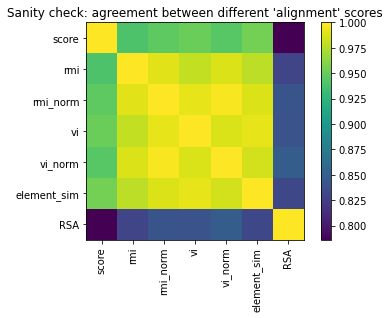

In [25]:
alignment_fields = ['score', 'rmi', 'rmi_norm', 'vi', 'vi_norm', 'element_sim', 'adj_spearman_r']
avg_corr, n = np.zeros((len(alignment_fields), len(alignment_fields))), np.zeros((len(alignment_fields), len(alignment_fields)))
for _, grp in align_df_all.groupby(['l2', 'l1', 'drop', 'layer', 'run']):
    corr = grp.loc[:,alignment_fields].corr().to_numpy()
    valid = ~np.isnan(corr)
    n[valid] += 1
    avg_corr[valid] += (corr[valid] - avg_corr[valid]) / n[valid]
plt.imshow(np.abs(avg_corr))
alignment_fields[-1] = 'RSA'
plt.xticks(*zip(*enumerate(alignment_fields)), rotation='vertical')
plt.yticks(*zip(*enumerate(alignment_fields)))
plt.title("Sanity check: agreement between different 'alignment' scores")
plt.colorbar()

Pick the metric we'll use going forward

In [26]:
ALIGNMENT_METRIC = 'element_sim'

Show alignment scores in untrained models

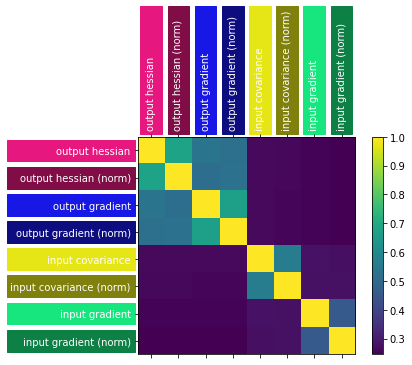

In [27]:
plot_alignment_stats(align_df_null, textlabel=True, value=ALIGNMENT_METRIC)
plt.savefig(f'figures/alignment_{ALIGNMENT_METRIC}_untrained.svg')
plt.show()

### 1st summary plot: just look at average alignment across everything

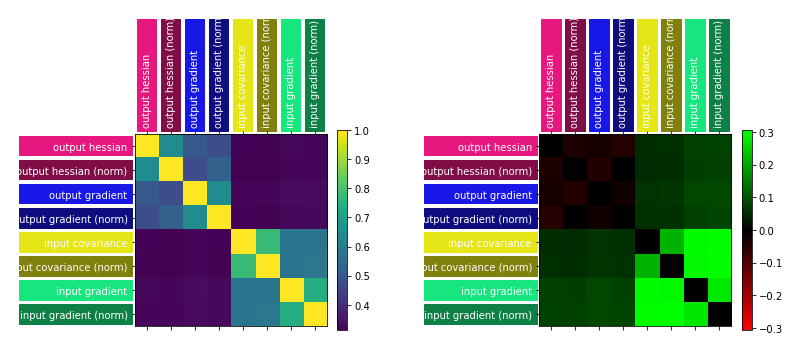

In [28]:
fig, ax = plt.subplots(1,2,figsize=(11.5, 5.75))
plot_alignment_stats(align_df_all, relative=None, ax=ax[0], textlabel=True, value=ALIGNMENT_METRIC)
plot_alignment_stats(align_df_all, relative=align_df_null, ax=ax[1], textlabel=True, value=ALIGNMENT_METRIC)
fig.tight_layout()
fig.savefig(f'figures/align_summary_{ALIGNMENT_METRIC}.svg')
plt.show()

### Show alignment stats per regularization method

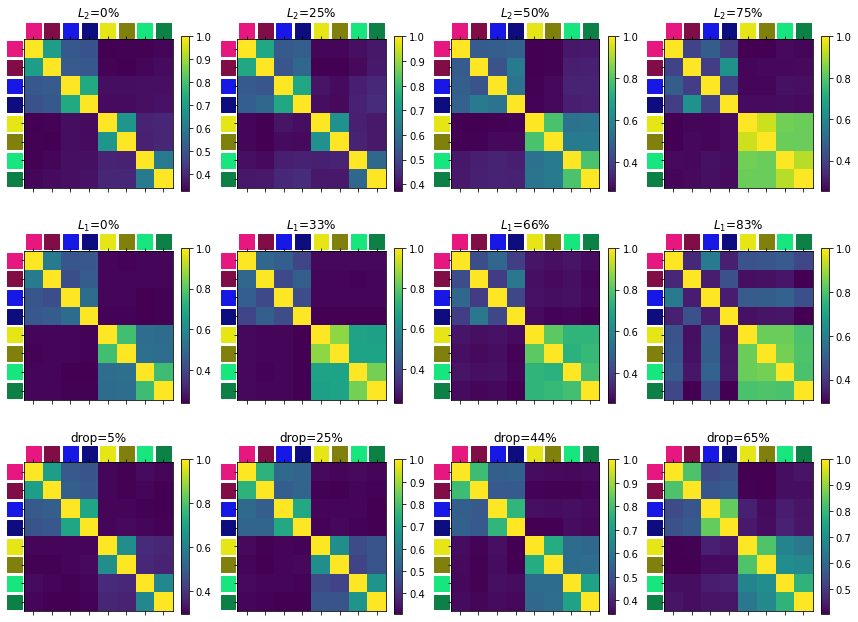

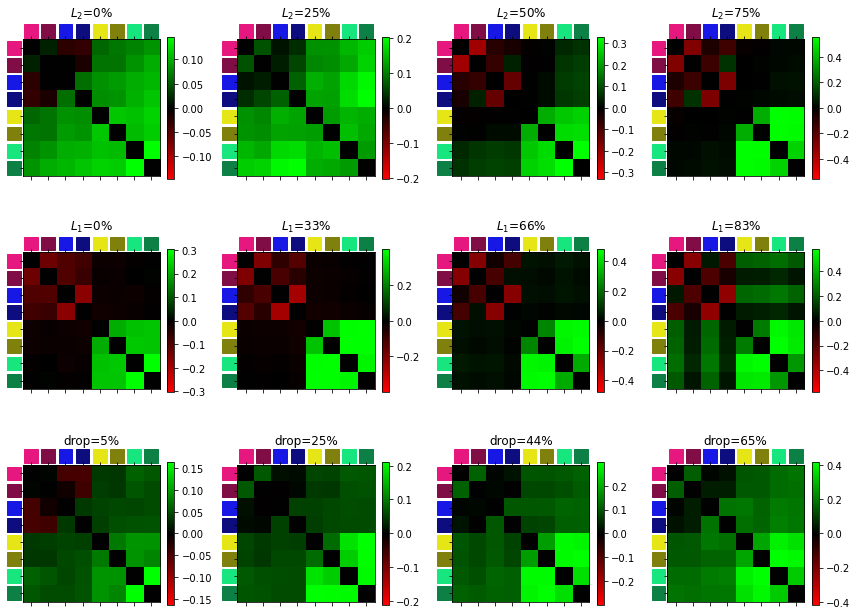

In [29]:
l2vals = regularization['l2'][0:7:2]
l1vals = list(regularization['l1'][0:5:2])+[regularization['l1'][5]]
dropvals = regularization['drop'][0:13:4]

for rel in [None, align_df_null]:
    fig, ax = plt.subplots(3,4,figsize=(12,9))
    for i, l2 in enumerate(l2vals):
        plot_alignment_stats(df_slice(align_df_all, {'l2':l2, 'l1':0., 'drop':0.}), relative=rel, ax=ax[0,i], textlabel=False, value=ALIGNMENT_METRIC)
        ax[0,i].set_title(f'$L_2$={int(regularization_amount("l2",l2)*100):d}%\n')
    for i, l1 in enumerate(l1vals):
        plot_alignment_stats(df_slice(align_df_all, {'l1':l1}), relative=rel, ax=ax[1,i], textlabel=False, value=ALIGNMENT_METRIC)
        ax[1,i].set_title(f'$L_1$={int(regularization_amount("l1",l1)*100):d}%\n')
    for i, drop in enumerate(dropvals):
        plot_alignment_stats(df_slice(align_df_all, {'drop':drop}), relative=rel, ax=ax[2,i], textlabel=False, value=ALIGNMENT_METRIC)
        ax[2,i].set_title(f'drop={int(regularization_amount("drop",drop)*100):d}%\n')

    fig.tight_layout()
    fig.savefig(f'figures/align_vs_reg_{ALIGNMENT_METRIC}{"_delta" if rel is not None else ""}.svg')
    plt.show()

### Show alignment stats per regularization method per layer

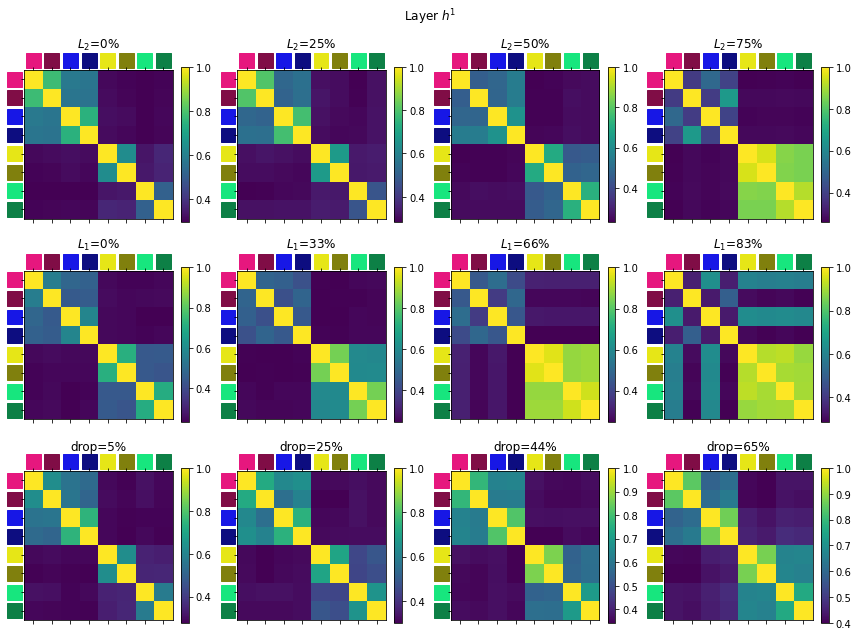

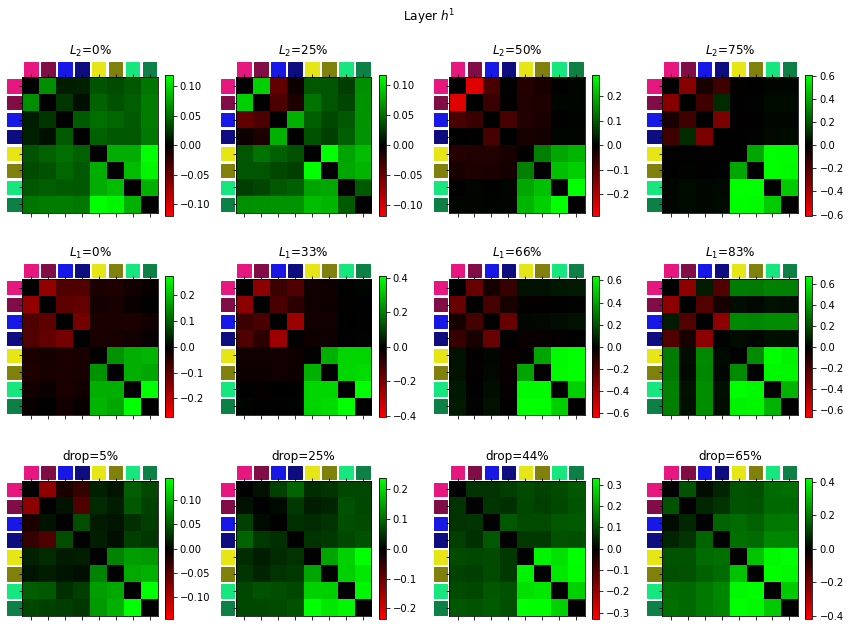

In [30]:
for rel in [None, align_df_null]:
    if rel is not None:
        rel = df_slice(rel, {'layer':0})
    fig, ax = plt.subplots(3,4,figsize=(12,9))
    for i, l2 in enumerate(l2vals):
        plot_alignment_stats(df_slice(align_df_all, {'layer':0, 'l2':l2, 'l1':0., 'drop':0.}), relative=rel, ax=ax[0,i], textlabel=False, value=ALIGNMENT_METRIC)
        ax[0,i].set_title(f'$L_2$={int(regularization_amount("l2",l2)*100):d}%\n')
    for i, l1 in enumerate(l1vals):
        plot_alignment_stats(df_slice(align_df_all, {'layer':0, 'l1':l1}), relative=rel, ax=ax[1,i], textlabel=False, value=ALIGNMENT_METRIC)
        ax[1,i].set_title(f'$L_1$={int(regularization_amount("l1",l1)*100):d}%\n')
    for i, drop in enumerate(dropvals):
        plot_alignment_stats(df_slice(align_df_all, {'layer':0, 'drop':drop}), relative=rel, ax=ax[2,i], textlabel=False, value=ALIGNMENT_METRIC)
        ax[2,i].set_title(f'drop={int(regularization_amount("drop",drop)*100):d}%\n')

    fig.suptitle('Layer $h^1$')
    fig.tight_layout()
    fig.savefig(f'figures/align_h1_vs_reg_{ALIGNMENT_METRIC}{"_delta" if rel is not None else ""}.svg')
    plt.show()

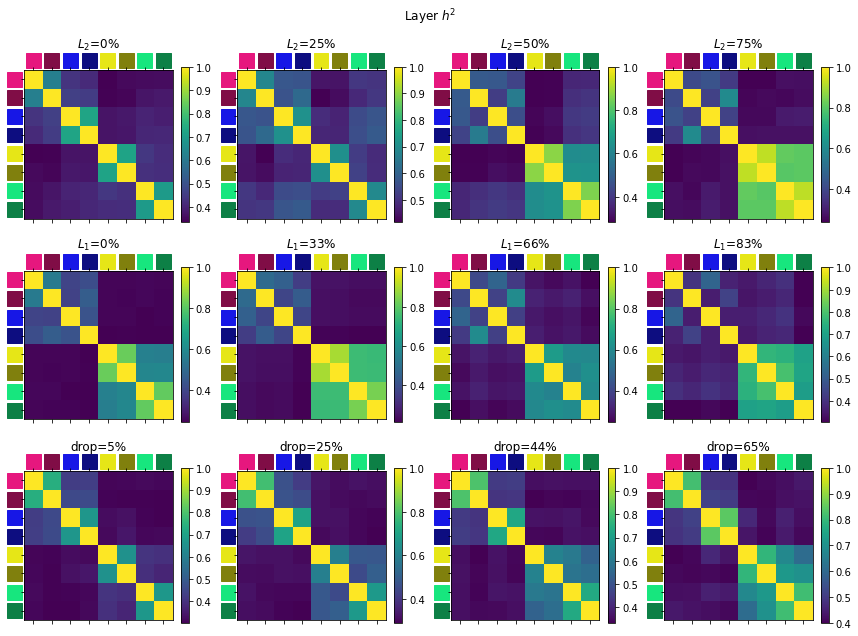

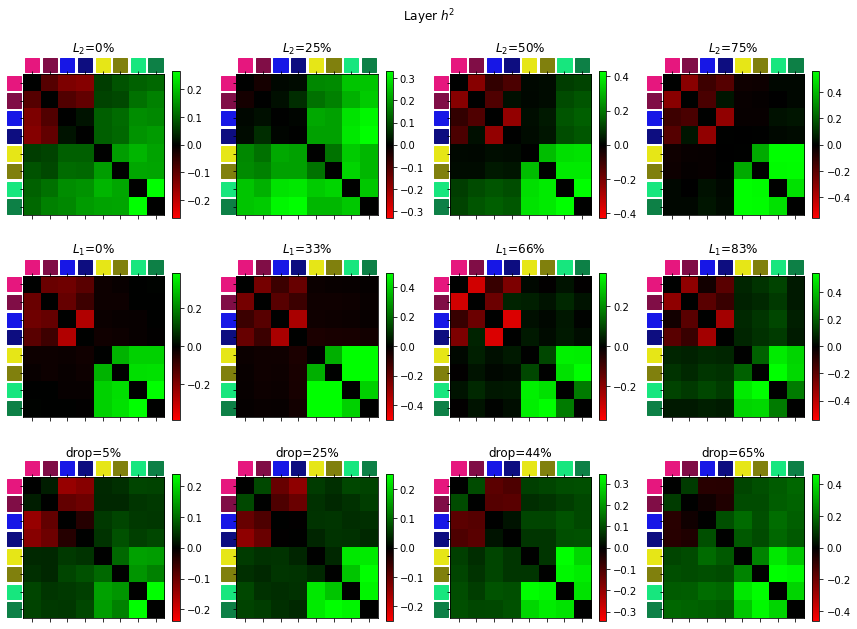

In [31]:
for rel in [None, align_df_null]:
    if rel is not None:
        rel = df_slice(rel, {'layer':0})
    fig, ax = plt.subplots(3,4,figsize=(12,9))
    for i, l2 in enumerate(l2vals):
        plot_alignment_stats(df_slice(align_df_all, {'layer':1, 'l2':l2, 'l1':0., 'drop':0.}), relative=rel, ax=ax[0,i], textlabel=False, value=ALIGNMENT_METRIC)
        ax[0,i].set_title(f'$L_2$={int(regularization_amount("l2",l2)*100):d}%\n')
    for i, l1 in enumerate(l1vals):
        plot_alignment_stats(df_slice(align_df_all, {'layer':1, 'l1':l1}), relative=rel, ax=ax[1,i], textlabel=False, value=ALIGNMENT_METRIC)
        ax[1,i].set_title(f'$L_1$={int(regularization_amount("l1",l1)*100):d}%\n')
    for i, drop in enumerate(dropvals):
        plot_alignment_stats(df_slice(align_df_all, {'layer':1, 'drop':drop}), relative=rel, ax=ax[2,i], textlabel=False, value=ALIGNMENT_METRIC)
        ax[2,i].set_title(f'drop={int(regularization_amount("drop",drop)*100):d}%\n')

    fig.suptitle('Layer $h^2$')
    fig.tight_layout()
    fig.savefig(f'figures/align_h2_vs_reg_{ALIGNMENT_METRIC}{"_delta" if rel is not None else ""}.svg')
    plt.show()